# Convert table image into csv file

In [1]:
from PIL import Image
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe" 

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#loading the best model saved while traing for prediction
model = load_model('mymodel_186')

In [ ]:
#source :- https://towardsdatascience.com/a-table-detection-cell-recognition-and-text-extraction-algorithm-to-convert-tables-to-excel-files-902edcf289ec

In [3]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
        # handle if we are sorting against the y-coordinate rather than
        # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        # construct the list of bounding boxes and sort them from top to
        # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

#creating function to input image path and in return we get text file 
def ocr_tesseract(img):
    text = pytesseract.image_to_string(img)  
    return text

def filter_word(x_min,y_min,x_max,y_max):
    #x_min,y_min,x_max,y_max = x_min,y_min,x_max,y_max
    crop = (x_min,y_min,x_max,y_max)
    cropped_table_ = img1.crop(crop)
    text = ocr_tesseract(cropped_table_)
    w = []
    for word in text.split("\n"):
        if word != '\x0c':
            w.append(str(word))

    if len(w):
        wo = ' '.join(w) 
    else:
        w.append(' ')
        wo = ' '.join(w) 
        
    return wo   


def table_csv(file_, path_):
    path = path_
    #read your file
    #file=r'exp2.png'
    file = file_
    img = cv2.imread(file,0)
    thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img_bin = 255-img_bin
    
    # Length(width) of kernel as 100th of total width
    kernel_len = np.array(img).shape[1]//100

    # Defining a vertical kernel to detect all vertical lines of image 
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    #Use vertical kernel to detect and save the vertical lines in a jpg
    image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
    vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
    
    #Use horizontal kernel to detect and save the horizontal lines in a jpg
    image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
    
    img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    #Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)

    x=np.ones([1024,1024])
    k= img_vh * x
    for i in range(1024):
        for j in range(1024):
            if k[i][j] != 255:
                #k[i][j][0] =  np.array([225,225,225]) 
                a = k[i][j]
                k[i][j] =  a - 255
    
    im=tf.keras.preprocessing.image.array_to_img(k[:,:,np.newaxis])
    im.save('new.bmp')
    
    fi=r'new.bmp'
    imgk = cv2.imread(fi,0)

    thresh, img_vh_ = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #thresh, img_vh_ = cv2.threshold(img,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    bitxor = cv2.bitwise_xor(img,img_vh)
    bitnot = cv2.bitwise_not(bitxor)
    
    # Detect contours for following box detection
    contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort all the contours by top to bottom.
    contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")
    
    #Creating a list of heights for all detected boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
    #Get mean of heights
    mean = np.mean(heights)
    
    #Create list box to store all boxes in  
    box = []
    # Get position (x,y), width and height for every contour and show the contour on image
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if (w<1000 and h<500):
            image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            box.append([x,y,w,h])
            
    x = list(sorted(set([i[0] for i in box])))

    j = 0
    collect = []
    for k in x:
        if j == 0:
            j = k
        else:
            collect.append(k - j)
            j = k
        
        
    x_collect = []
    for i in range(2):
        if i == 0:
            if int(np.mean(collect)*2) <= x[i]:
                x_collect.append(x[i]-int(np.mean(collect)*2))
            else:
                x_collect.append(0)
            
        else:
            if int(np.mean(collect)*2) <= 1024-x[len(x)-1]:
                x_collect.append(x[len(x)-1]+int(np.mean(collect)*2))
            else:
                x_collect.append(1024)
    x.extend(x_collect)  

    x = sorted(x)   
    
    y = list(sorted(set([i[1] for i in box])))

    j = 0
    collect_y = []
    for k in y:
        if j == 0:
            j = k
        else:
            collect_y.append(k - j)
            j = k
        
    y_collect = []
    for i in range(2):
        if i == 0:
            if int(np.median(collect_y)*2) <= y[i]:
                y_collect.append(y[i]-int(np.median(collect_y)*2))
            else: 
                y_collect.append(0)
        else:
            if int(np.median(collect_y)*2) <= 1024-y[len(y)-1]:
                y_collect.append(y[len(y)-1]+int(np.median(collect_y)*2))
            else:
                y_collect.append(10240)

    y.extend(y_collect)   

    y = sorted(y)
    
    imk=Image.open(path)
    x_min=x[1] - 20
    y_min=y[1]
    x_max=x[len(x)-2]
    y_max=y[len(y)-2]
    crop = (x_min,y_min,x_max,y_max)
    cropped_table = imk.crop(crop)
    cropped_table.save('text.png')
    
    li = []
    img1=Image.open('output1.png')
    #print(file)
    #img1=Image.open(file)
    for i , m in enumerate(y):
        if i +1 != len(y):
            string = []
            for j , n in enumerate(x):
                if j +1 != len(x):
                    #print('yes')
                    x_min = n
                    y_min = m
                    x_max = x[j+1]
                    y_max = y[i+1]
                    
                    crop = (x_min,y_min,x_max,y_max)
                    cropped_table_ = img1.crop(crop)
                    text = ocr_tesseract(cropped_table_)
                    w = []
                    for word in text.split("\n"):
                        if word != '\x0c':
                            w.append(str(word))

                    if len(w):
                        wo = ' '.join(w) 
                    else:
                        w.append(' ')
                    wo = ' '.join(w)
                    #words = filter_word()
                    words = wo
                    string.append(words)
                    #print(words)
            li.append(string) 

    # name of csv file 
    filename = "records.csv"
    
    # writing to csv file 
    with open(filename, 'w') as csvfile:
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerows(li)
        
    data = pd.read_csv('records.csv',encoding= 'unicode_escape')  
    
    #text('text.png')
    
    return data 

    

In [4]:
import cv2
import pytesseract
from pytesseract import Output
import pandas as pd

def text(path):
    #img = cv2.imread("tabular_data_1_the_perfect_format.png")
    path_ = path
    img = cv2.imread(path_)
    img = cv2.resize(img, (int(img.shape[1] + (img.shape[1] * .1)),
                       int(img.shape[0] + (img.shape[0] * .25))),
                 interpolation=cv2.INTER_AREA)

    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


    custom_config = r'-l eng --oem 3 --psm 6 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-:.$%./@& *"'
    #custom_config='--psm 10'
    d = pytesseract.image_to_data(img_rgb, config=custom_config, output_type=Output.DICT)
    df = pd.DataFrame(d)

    # clean up blanks
    df1 = df[(df.conf != '-1') & (df.text != ' ') & (df.text != '')]
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    # sort blocks vertically
    sorted_blocks = df1.groupby('block_num').first().sort_values('top').index.tolist()
    for block in sorted_blocks:
        curr = df1[df1['block_num'] == block]
        sel = curr[curr.text.str.len() > 3]
        # sel = curr
        char_w = (sel.width / sel.text.str.len()).mean()
        prev_par, prev_line, prev_left = 0, 0, 0
        text = ''
        for ix, ln in curr.iterrows():
            # add new line when necessary
            if prev_par != ln['par_num']:
                text += '\n'
                prev_par = ln['par_num']
                prev_line = ln['line_num']
                prev_left = 0
            elif prev_line != ln['line_num']:
                text += '\n'
                prev_line = ln['line_num']
                prev_left = 0

            added = 0  # num of spaces that should be added
            if ln['left'] / char_w > prev_left + 1:
                added = int((ln['left']) / char_w) - prev_left
                text += ' ' * added
            text += ln['text'] + ' '
            prev_left += len(ln['text']) + added + 1
        text += '\n'
        print(text)

In [5]:
#function which predict table sub image from image and convert them into dataframe
def prediction(filepath):
    path = filepath
    #reading  , resizing and normalizing for image data
    images = tf.io.read_file(path)
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, [256, 256])  #Decode a JPEG-encoded image to a uint8 tensor
    images = tf.cast(images, tf.float32) / 255.0 # normalizing image
    
    mask1, mask2 = model.predict(images[np.newaxis,:,:,:])
    table_mask, column_mask = masks(mask1, mask2)

    im1=tf.keras.preprocessing.image.array_to_img(images)
    im1.save('image.bmp')
        
    im2=tf.keras.preprocessing.image.array_to_img(table_mask)
    im2.save('table_mask.bmp')
        
    im3=tf.keras.preprocessing.image.array_to_img(column_mask)
    im3.save('column_mask.bmp')
    
    im4  = Image.open(path)
    im4=im4.resize((1024,1024),Image.ANTIALIAS)
    im4.save('image.bmp')

    im5 = Image.open('/content/content/MyDrive/table_extraction/table_mas/table_mask8.bmp')
    im5=im5.resize((1024,1024),Image.ANTIALIAS)
    im5.save('table_mask.bmp')
    
    img_  = Image.open('image.bmp')
    img_mask = Image.open('table_mask.bmp')

    img_ = img_mask.convert('L')    # grayscale
    img_.putalpha(img_mask)
    img_.save('output.png')
    
    img = cv2.imread('image.bmp',cv2.IMREAD_UNCHANGED)
    img_table = cv2.imread('table_mask.bmp',cv2.IMREAD_UNCHANGED)

    x=np.ones([1024,1024 , 3])
    k= img * x
    for i in range(1024):
        for j in range(1024):
            if img_table[i][j] == 0:
                k[i][j] =  np.array([0,0,0])

    for i in range(1024):
        for j in range(1024):
            if k[i][j][0] == 0:
                k[i][j][0] =  255   

    for i in range(1024):
        for j in range(1024):
            if k[i][j][0] != 255:
                a = k[i][j][0]
                k[i][j][0] =  a - 255
                
    im=tf.keras.preprocessing.image.array_to_img(k)
    im.save('test.png') 
    
    data = table_csv('test.png')
    data.to_csv('file.csv')
    return data

# Showing result with examples

# Example 1

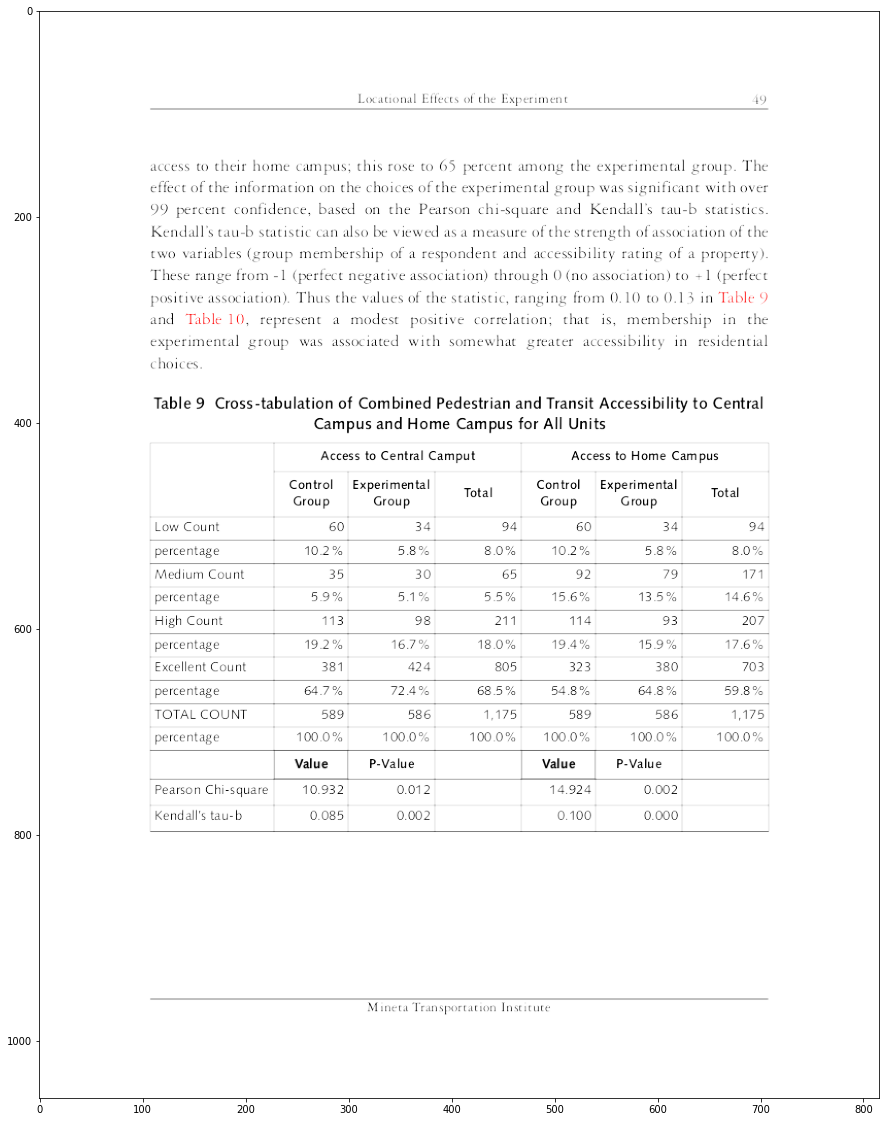

In [4]:
#showing original image
image = cv2.imread('10.1.1.192.1805_60.bmp',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

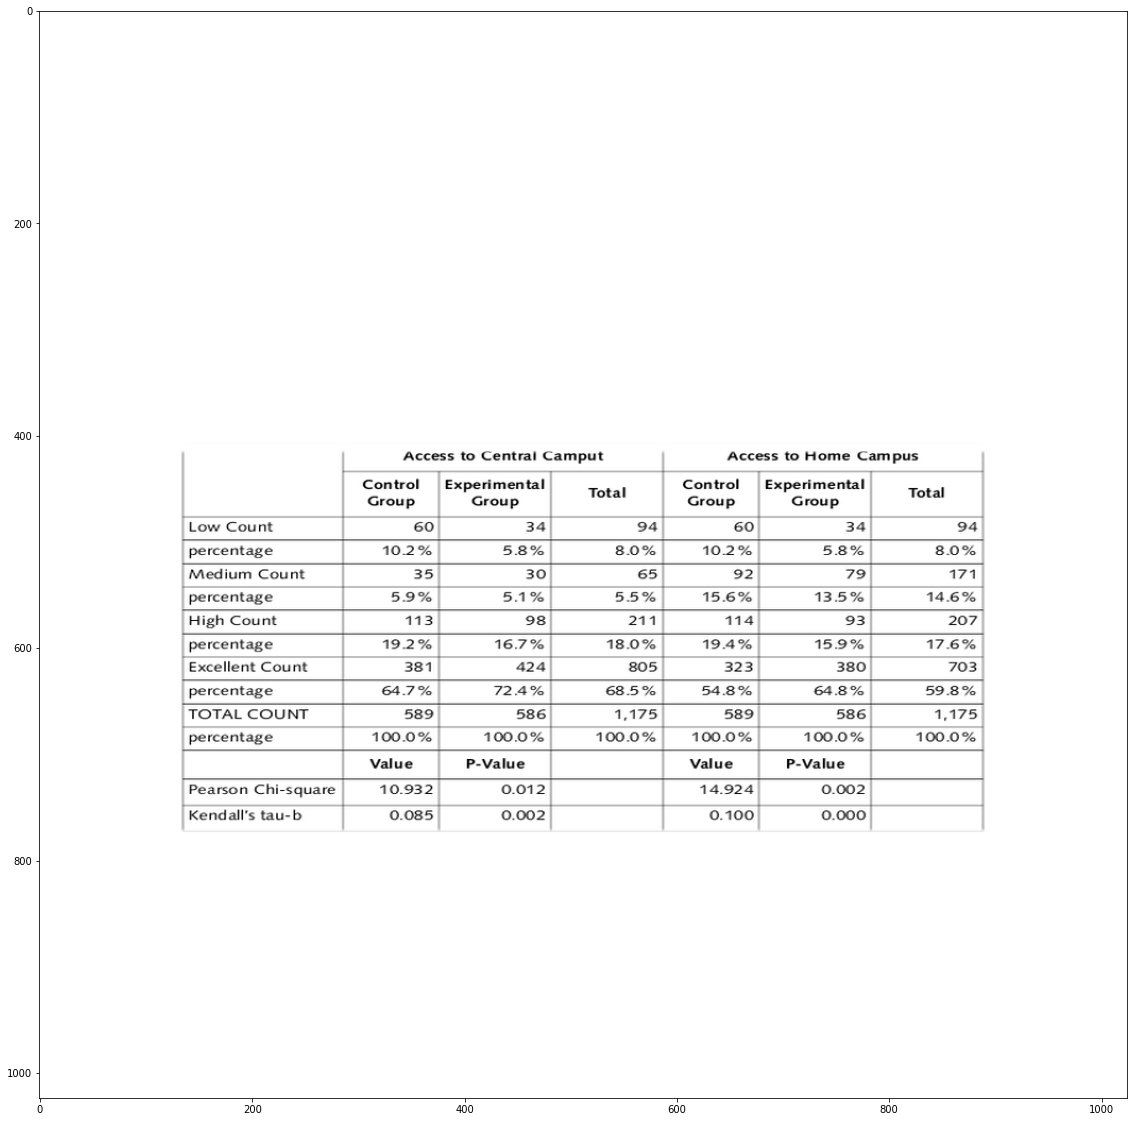

In [16]:
#showing cropped image with predicted mask
image = cv2.imread('output.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [9]:
data = prediction('10.1.1.192.1805_60.jpeg')

In [11]:
#showing csv file
data

.1  .2                  .3             .4                  .5  .6  \
0                                           Acce     ss to Central ¢       
1                                  Control Group  Experimental Group       
2                       Low Count                                          
3                      percentage          10.2%                           
4                                             35                  30       
5                      percentage            59%                           
6                      High Count            113                           
7                      percentage          19.2%               16.7%       
8                 Excellent Count            381               5 424       
9                      percentage          64.7%                724%       
10                   TOTAL COUNT.            589                           
11                     percentage         100.0%              100.0%       
12                                         Value             P-Value       
13             Pearson Chi-square         10.932               0.012       
14                Kendall's tau-b          0.085               0.002       
15                                                                         
16                                                                         

        .7             .8  .9                 .10     .11  .12  
0   amput            Acc           ess to Home C  am pus       
1    Total  Control Group      Experimental Group   Total       
2                                                               
3                   10.2%                                       
4       65             92                      79     471       
5                                                               
6                                                    207       
7    18.0%          19.4%                    159%               
8      805            323                     380     703       
9     685%           548%                    C48%    598%       
10   1,175                                    586   1,175       
11  100.0%         100.0%                  100.0%  100.0%       
12                  Value                 P-value               
13                 14.924                   0.002               
14                  0.100                   0.000               
15                                                              
16

In [35]:
text('text.png')


                        Access to Central Camput          Access to Home Campus 
                   Control  Experimental    4444      Control  Experimental   4 
                    Group      Group                  Group       Group 
 Low Count               60          34          94        60          34          94 
percentage            10.2%       58%          80%      10.2%        58%         8.0% 
 Medium Count            35          30          65        92          79         171 
percentage            59%         51%         55%       15.6%       135%        14.6% 
 High Count             113          98         211       114          93         207 
percentage           19.2%        16.7%       18.0%     19.4%       15.9%       17.6% 
 Excellent Count        381         424        805        323         380         703 
percentage           64.7%       A%           685%      54.8%       64.8%       59.8% 
 TOTAL COUNT            589         586       4175        589       

# Example 2

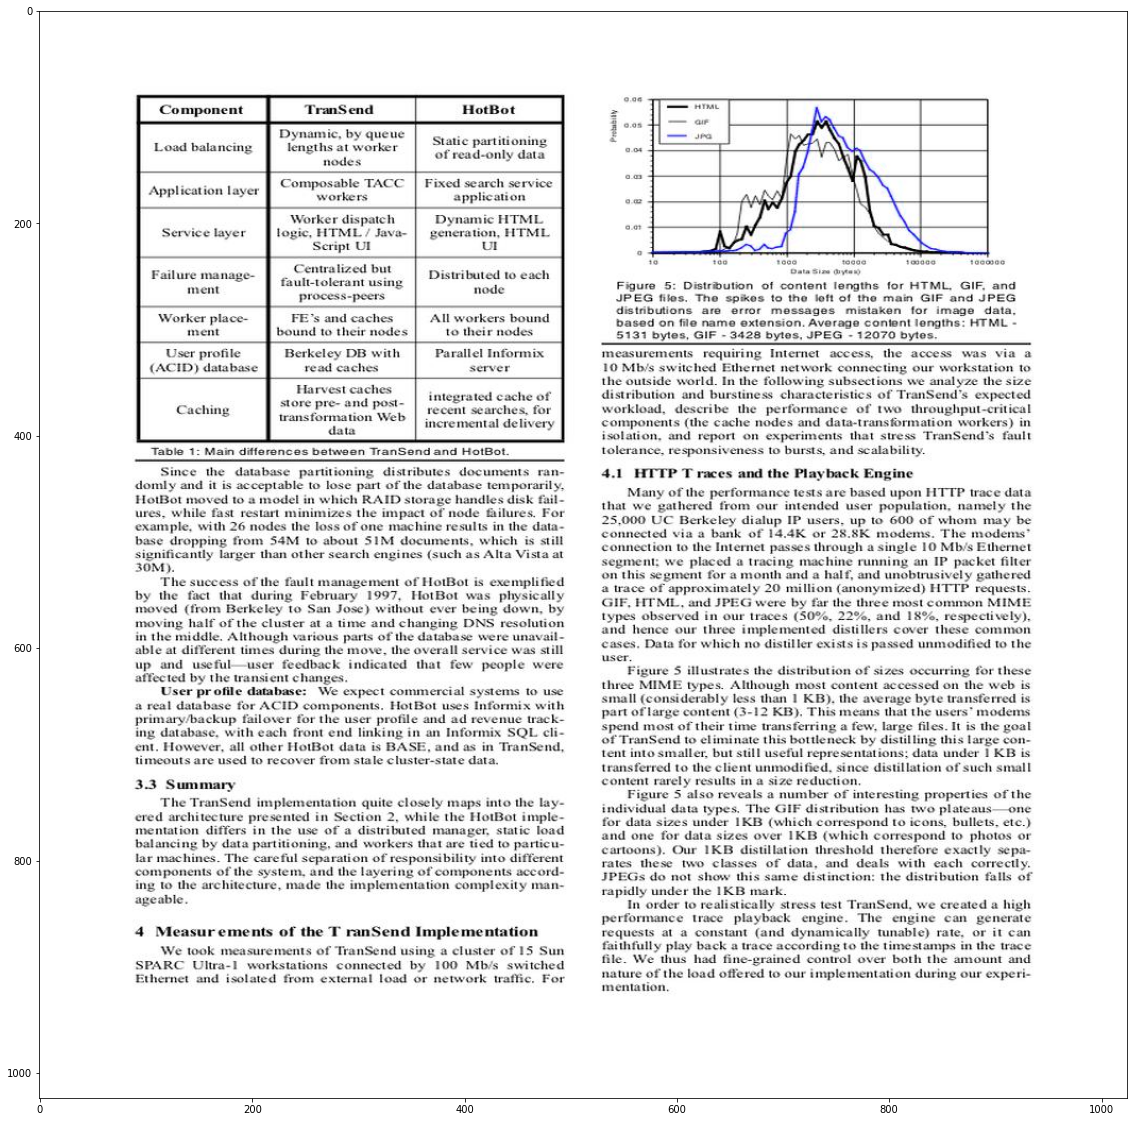

In [12]:
#showing original image
image = cv2.imread('10.1.1.1.2034_8.jpeg',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [14]:
data = prediction('10.1.1.1.2034_8.jpeg')


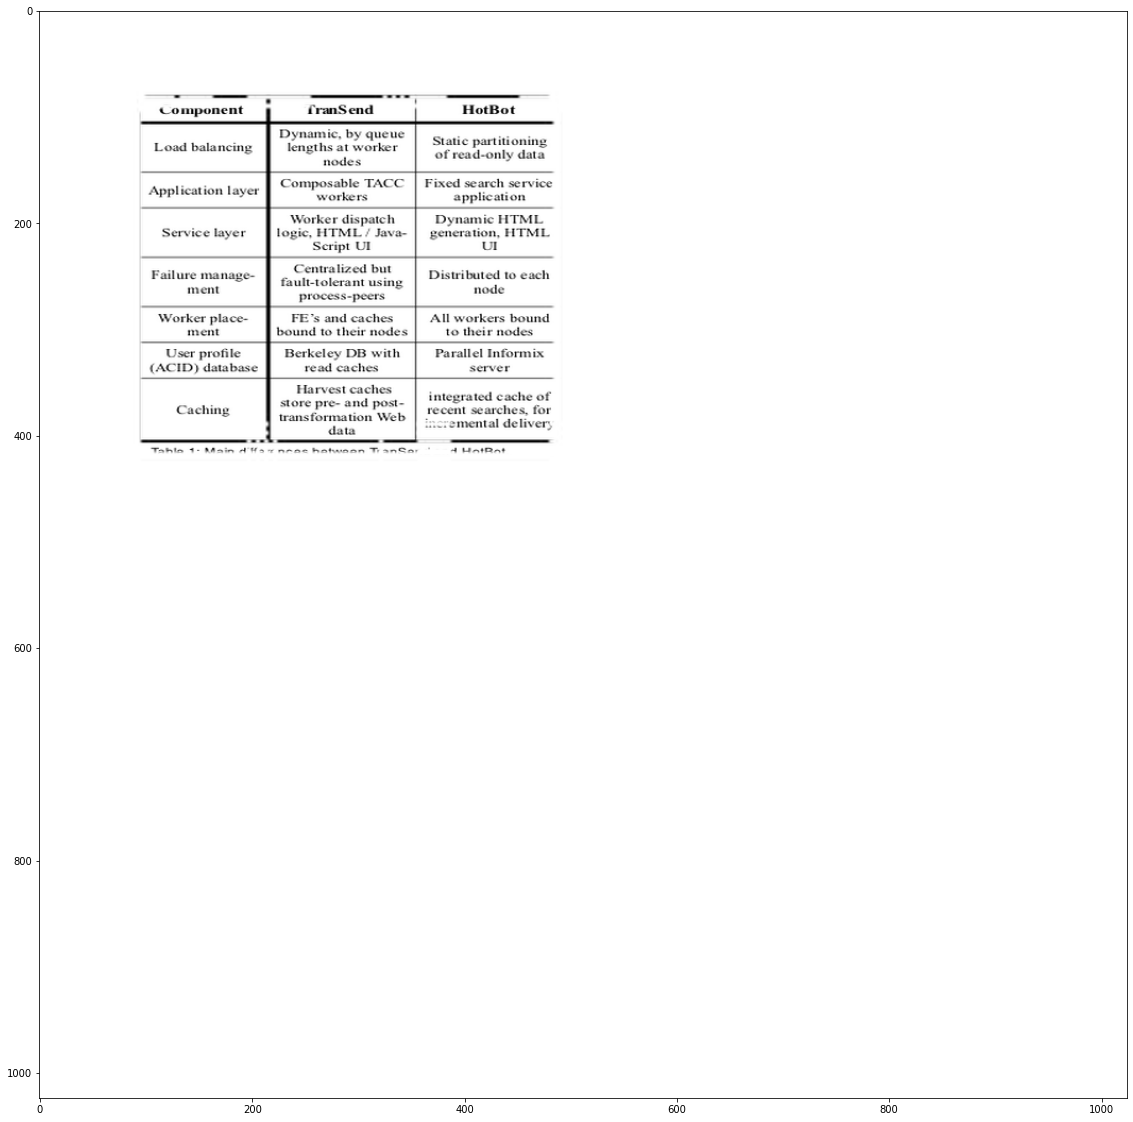

In [15]:
#showing cropped image with predicted mask
image = cv2.imread('output.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [16]:
#showing csv file
data

.1  .2                            .3  \
0                                             
1                                             
2                                             
3                                             
4                                 Component   
5                           Load balancing.   
6                         Application Layer   
7                             Service layer   
8                     Failure manage- ment   
9                        Worker place- ment   
10             User profile (ACID) database   
11                                  Caching   
12                                            

                                                   .4  .5  \
0                                                           
1                                                           
2                                                           
3                                                           
4                                            iranSend       
5           Dynamic, by queue Tengths at worker nodes       
6                                   ! Composable TACC       
7   Worker dispatch logic, HTML / Java- Script UI...       
8   Centralized but fault-tolerant using process-p...       
9                                                           
10                                                          
11  Harvest caches  store pre- and post-  transfor...       
12                                                          

                                                   .6  .7  .8  
0                                                              
1                                                              
2                                                              
3                                                              
4                                              HotBot          
5               Static partitioning of read-only data          
6                                                              
7                                                              
8                            Distributed to each node          
9                 All workers bound to their nodes             
10                                                             
11     imtegrated cache of recent searches, for om...          
12

In [36]:
text('text.png')


                       Dynamic. by queue    60         isting 
     Load  balancing    lengths at worker   Sarre gar   pes 
                                             of read-only data 
                             nodes 
                       Composable  TACC    Fixed search service 
                                               Sensi 
                        Worker  dispatch     Dynamic  HTML 
       Service layer  togic. HTML  / Java-  generation HTML 
                            Seript Ul              ur 
                        Centralized but      pyistributed to each 
                       fault-tolerant using       ale 
                          process-peers 
      Worker place-      FEs and caches     All  workers bound 
          ment        bound  to their nodes   to their nodes 
       User profile     Berkeley DB with     Parallel Informix 
     ACID   database      read caches            server 
                         Harvest caches               .      - 
      

# Example 3

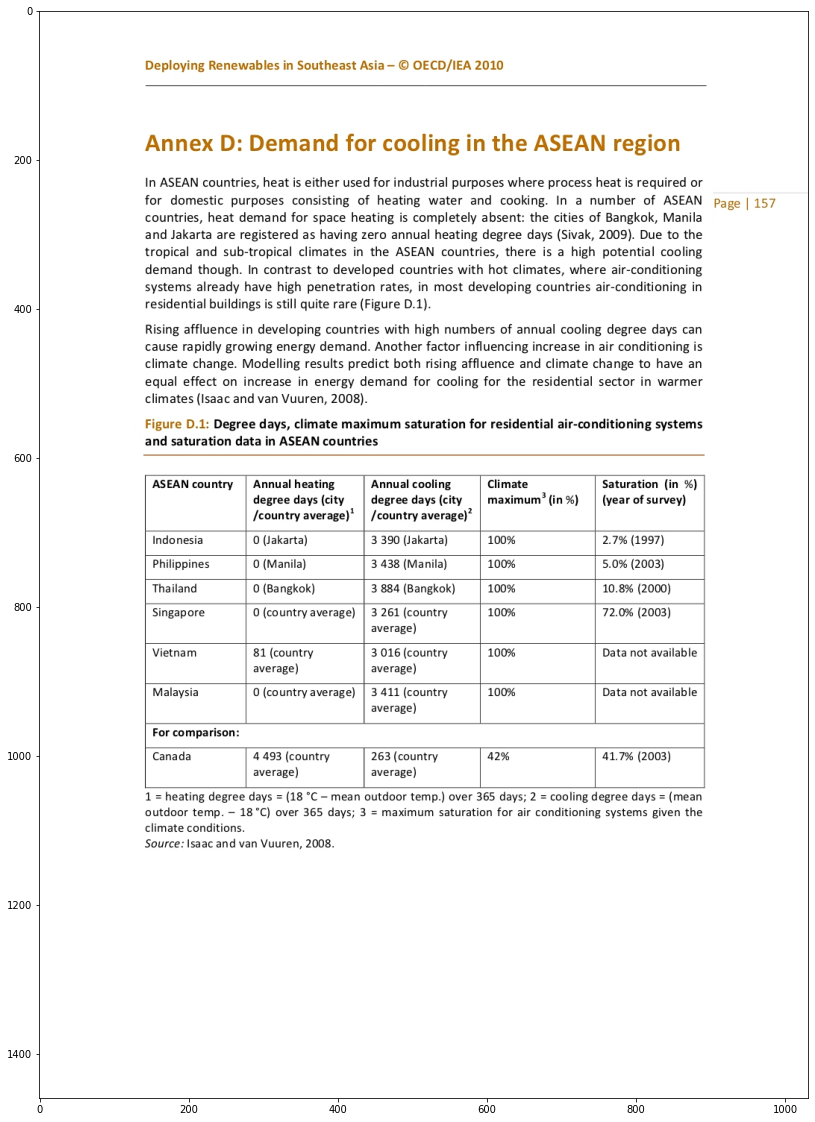

In [32]:
#showing original image
image = cv2.imread('POD_0326.jpg',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [33]:
data = prediction('POD_0326.jpg')

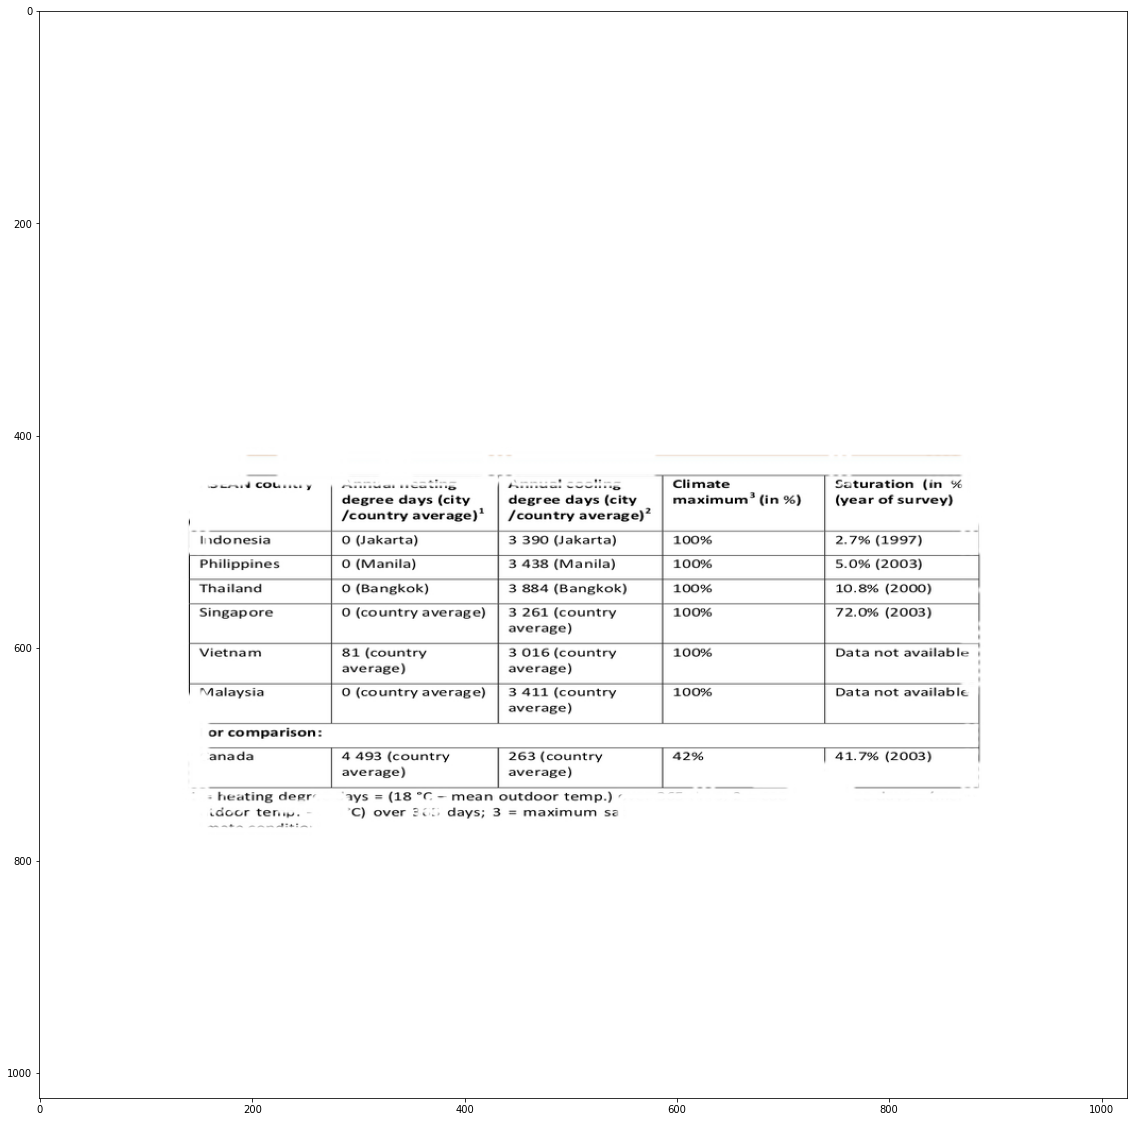

In [34]:
#showing cropped image with predicted mask
image = cv2.imread('output.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [63]:
#showing csv file
data

.1            .2                    .3                   .4  \
0                                                                    
1          SEAN country                        eating sanimameaadl   
2                                        ieee                        
3                                                                    
4              idonesia           | 0 Vakarta                        
5            hilippines                                              
6               hailand           | 0 (Bangke                        
7              ingapore            0 (country            javerage)   
8                ietnam                                              
9                                                                    
10             Aalaysia            0 (country            javerage)   
11                                                                   
12            ee  anada  4 493 (cot average)                iatry   
13                                                                   
14                                                                   
15                                                                   

                          .5    .6  .7  .8          .9                .10  
0                                                                          
1   Annual cooling nee al                              ion (in %, ir idl  
2                   ey ae                                                  
3                                                                          
4            | 3390 Vakarta)                 | 2.7% (4               997)  
5            +3 438 (Manila)  100%           | 5.0% (2               003)  
6            3 884 (Bangkok)                | 10.89% (              2000)  
7    3 261 (country average)  100%             72.0% (              2003)  
8    3.016 (country average)  100%                           ot available  
9                                                                          
10   3 411 (country average)  100%                            t available  
11                                                                         
12     263 (country average)   a2%             aL 7% |              2003)  
13                                                                         
14                                                                         
15

In [6]:
text('text.png')


 Deploying Renewables  in Southeast Asia- @ OECD/IEA 2010 
 Annex       D:   Demand         for  cooling       in the    ASEAN        re 
 In ASEAN countries heat is either used for industrial purposes where process heat is 
 for domestic  purposes consisting of heating water and  cooking. In a number 
 countries heat demand  for space heating is completely absent: the cities of Bang 
 and Jakarta are registered as having zero annual heating degree days Sivak 2009. 
 tropical and sub-tropical climates in the ASEAN countries there is a high poten 
 demand   though. In contrast to developed countries with hot climates where air-c 
 systems already have high penetration rates in most developing countries air-con 
 residential buildings is still quite rare Figure D.1. 
 Rising affluence in developing countries with high numbers of annual cooling degrs 
 cause rapidly growing energy demand. Another factor influencing increase in air cor 
 climate change. Modelling results predict both risi

# Exammple 4

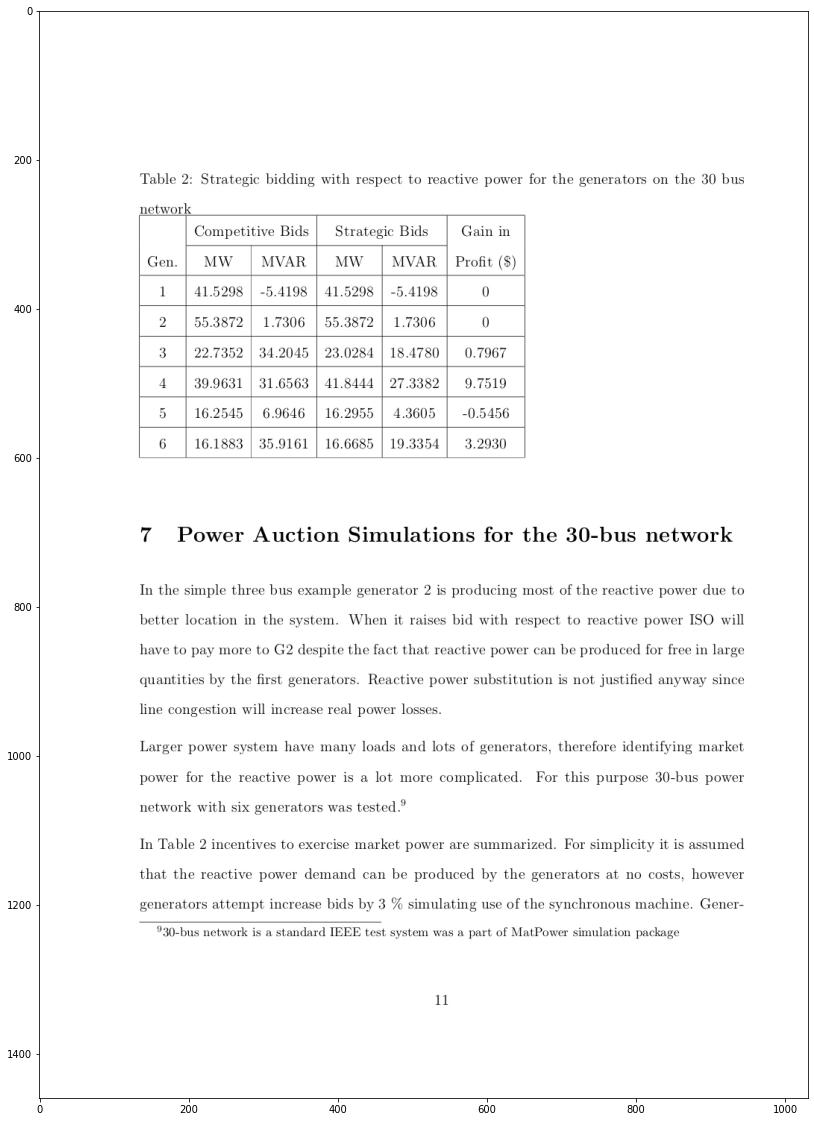

In [38]:
#showing original image
image = cv2.imread('POD_0240.jpg',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [39]:
data = prediction('POD_0240.jpg')


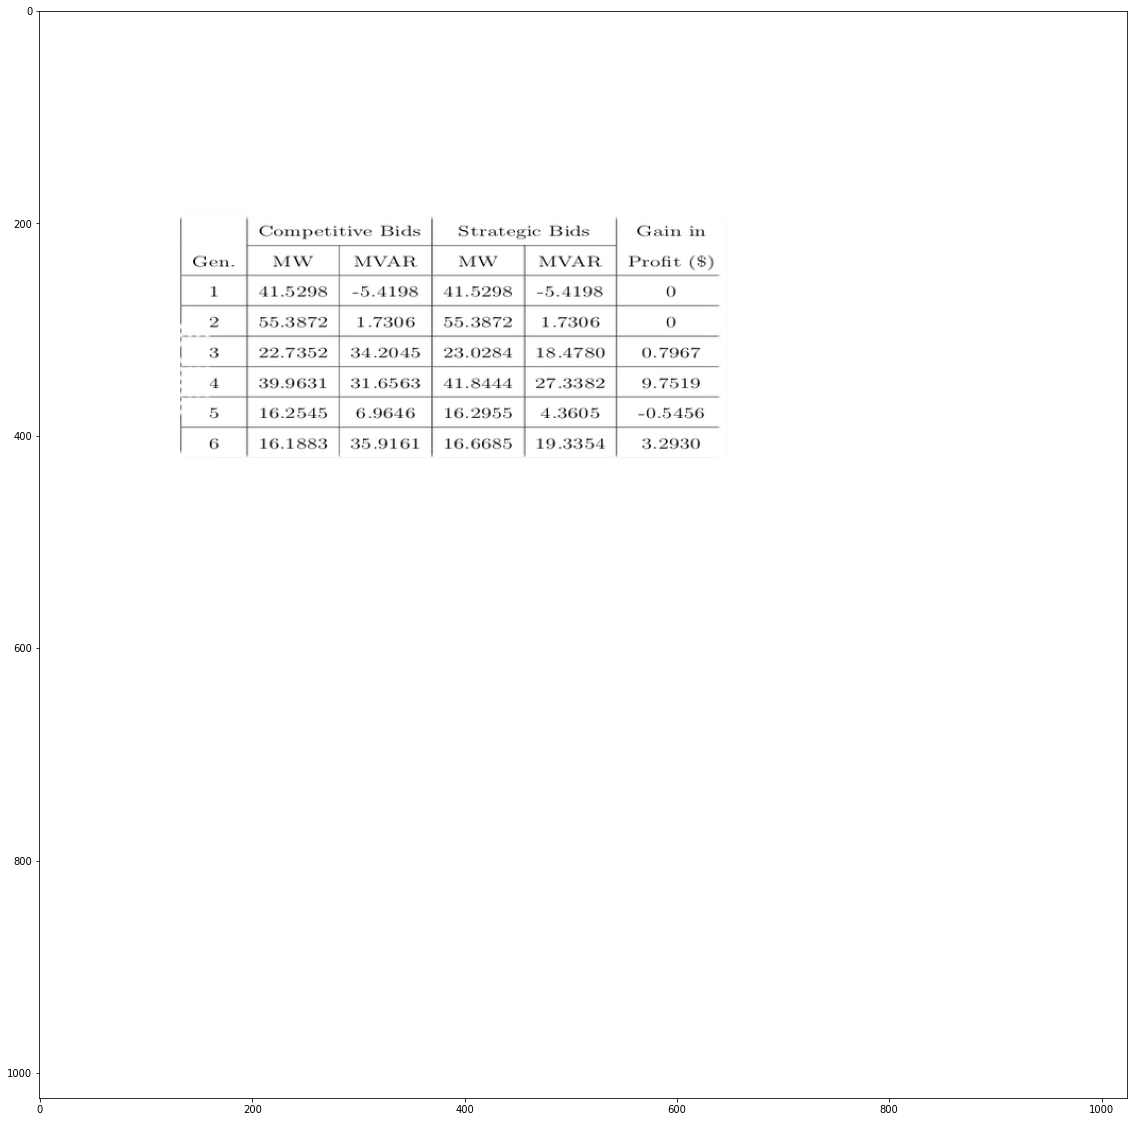

In [40]:
#showing cropped image with predicted mask
image = cv2.imread('output.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [44]:
#showing csv file
data

.1   .2  .3      .4         .5                .6       .7          .8  \
0                              ompeti         tive Bids  Strateg               
1          ten                     MW              MVAR                 MVAR   
2                               [5298           5.4198,              5.4198,   
3                              5.3872                        872      1.7306   
4                              2.7352           34.2045  23.0284     18.4780   
5           iS                 1.9631                    41.8444         382   
6            a                                                        4.3605   
7                      | |  5.1883           35.9161                 19.3354   
8                                                                              
9                                                                              
10                                                                             

           .9  
0     Gain in  
1   Profit (<  
2              
3              
4      0.7967  
5              
6              
7              
8              
9              
10

# Example 5

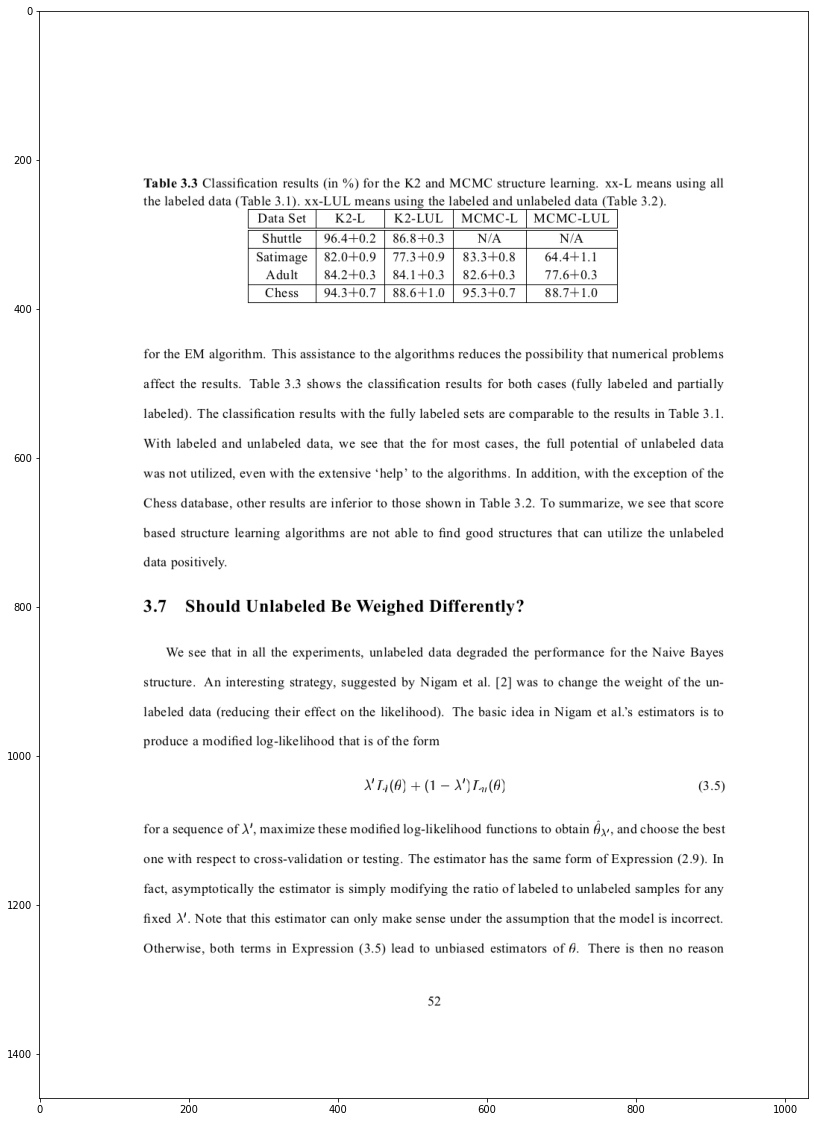

In [30]:
#showing original image
image = cv2.imread('POD_0185.jpg',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [46]:
data = prediction('POD_0185.jpg')


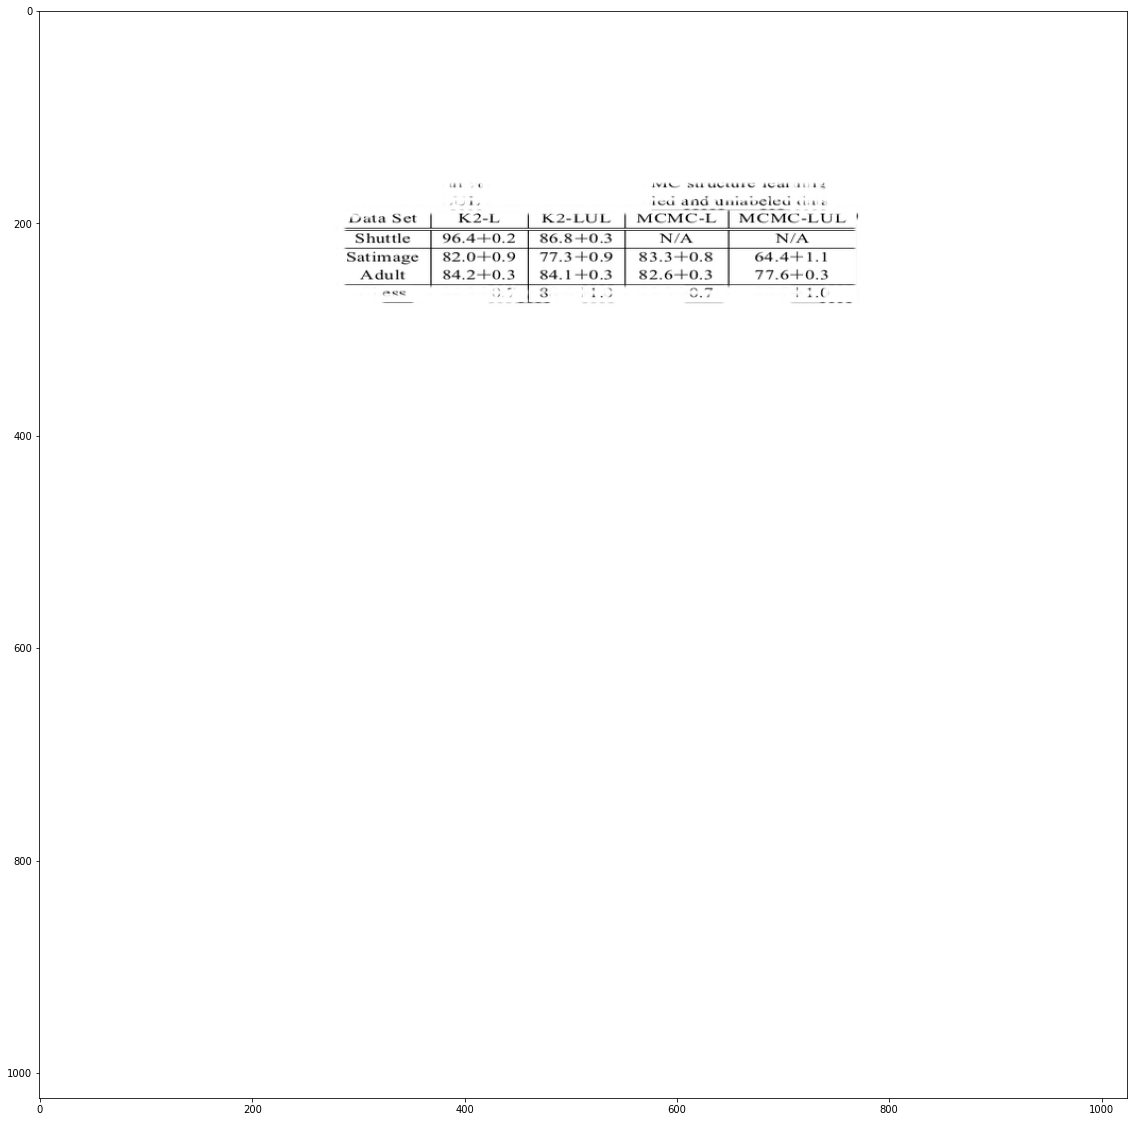

In [48]:
#showing cropped image with predicted mask
image = cv2.imread('output.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [29]:
#showing csv file
data

.1  .2             .3  .4              .5  .6                 .7  .8  \
0                                                                             
1                                                                             
2                                                                             
3                       hutt            06.440.2                86.8403       
4                 tims A dul  ee  82.0+0.9 84.24      77.34+0.9 84.140.       
5                                       94.3+0.7               88.6+1.0       
6                                                                             
7                                                                             
8                                                                             
9                                                                             
10                                                                            

      .9              .10  .11  .12  .13  .14  
0                                              
1                                              
2                                              
3                     N/A                      
4         64.4411 77.6+0.                      
5   +0.7        S8.74+1.0                      
6                                              
7                                              
8                                              
9                                              
10

# Example 6

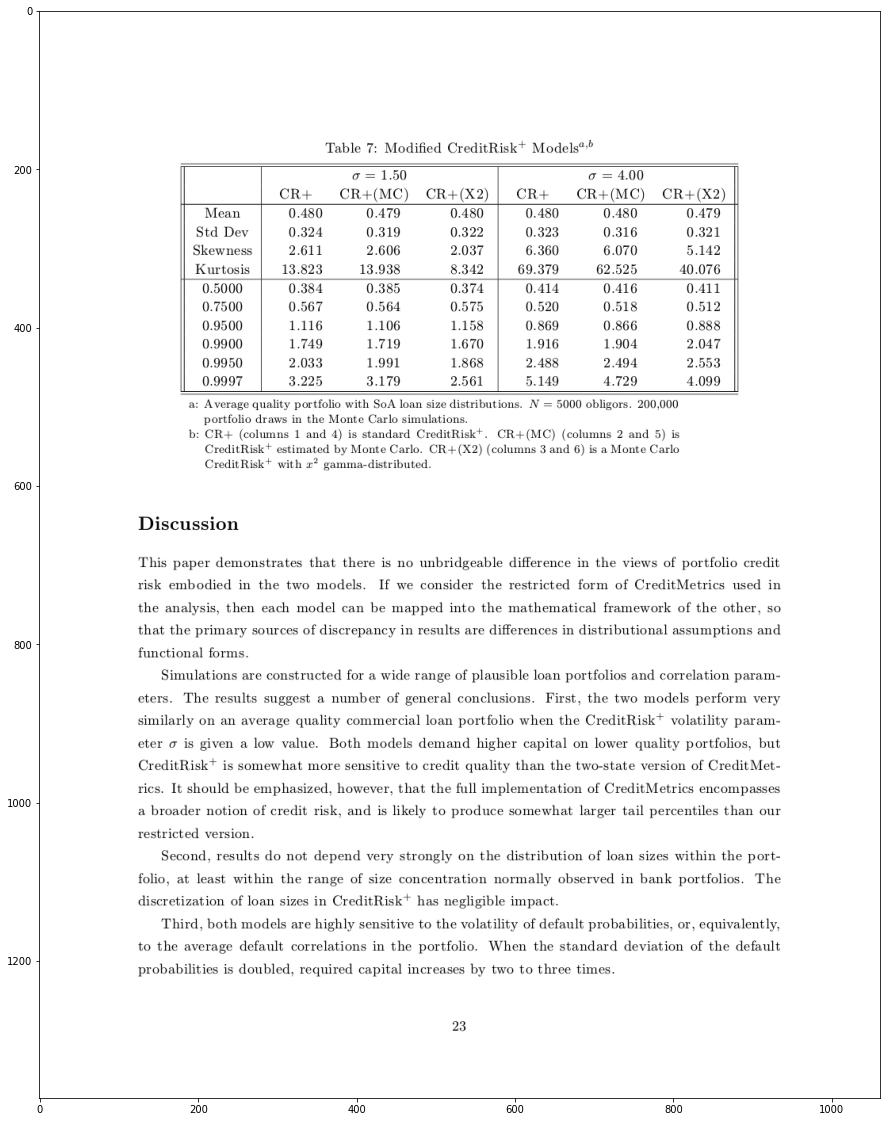

In [17]:
#showing original image
image = cv2.imread('POD_0184.jpg',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [15]:
data = prediction('POD_0184.jpg')

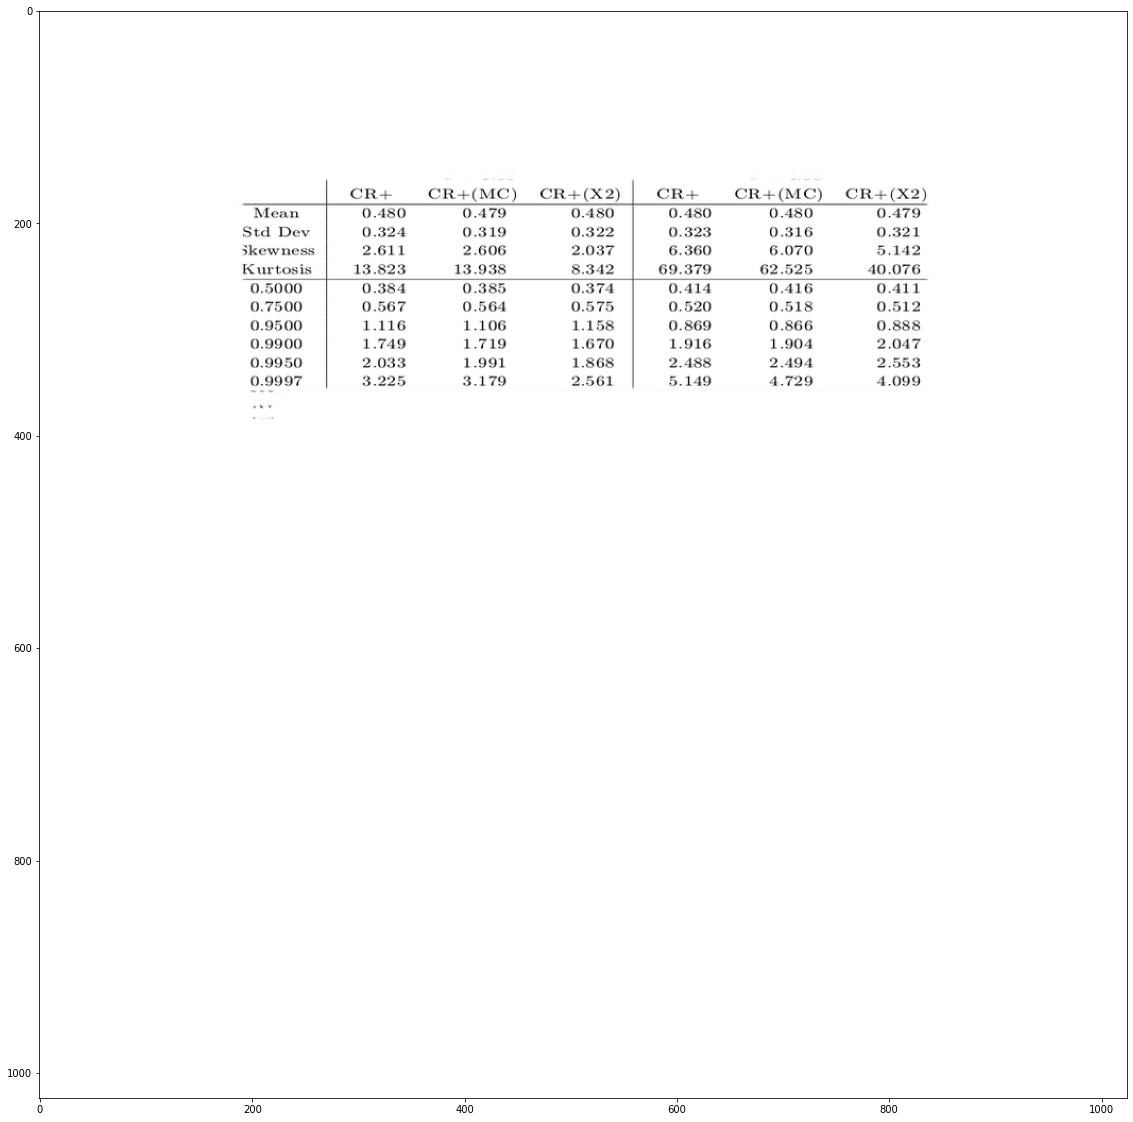

In [50]:
#showing cropped image with predicted mask
image = cv2.imread('output.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [16]:
#showing csv file
data

.1                               .2  .3  .4  \
0                                                           
1                                                           
2     Ste ike Ce                ean Dev wes: foci           
3                    5000 7500 1500 1900 1950 007           
4                                                           
5                                                           
6                                                           

                                                .5                       .6  \
0                                                                             
1                             o=150 24 CR+(MC) CR+                     (x2)   
2  480 B24 611 823  0.479 0.319 2.606 13.938  ones          480 322 037 342   
3         0.385 0.564 1.106 1.719 1.991 170     ee  374 575 158 670 868 eal   
4                                                                             
5                                                                             
6                                                                             

                  .7                .8  .9  \
0                                            
1                CR-                         
2  0.4 0.3 6.3  69.3       80 23 60          
3                        tees weae  40       
4                                            
5                                            
6                                            

                                            .10  
0                                                
1                              00  C) CR+(X2     
2                 we  0.479 0.321 5.142  40.076  
3  ee ee Fe  0.411 0.512 0.888 2.047 2.553 aono  
4                                                
5                                                
6

# Example 7

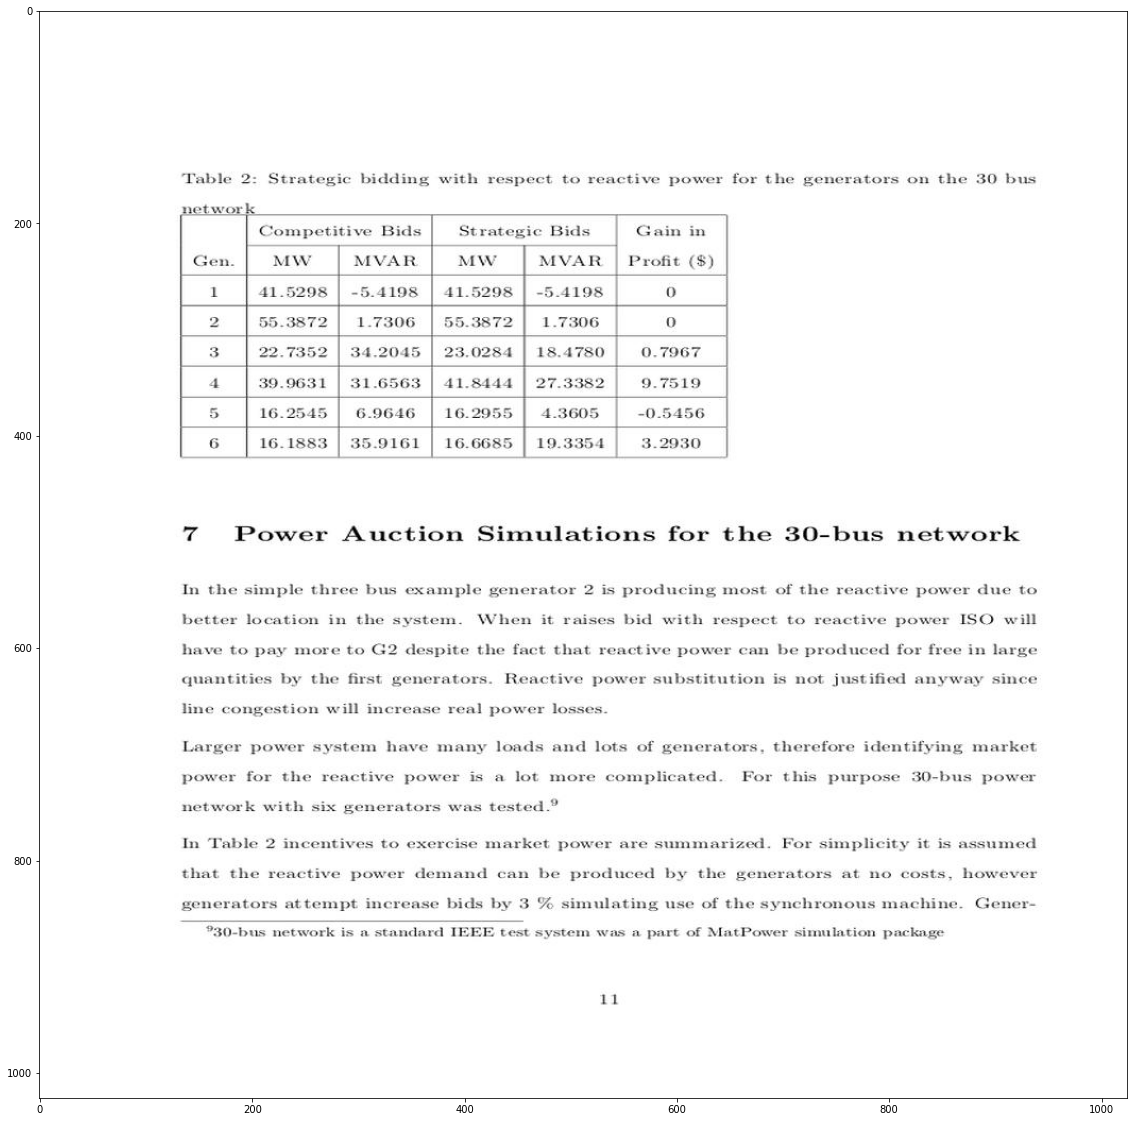

In [18]:
#showing original image
image = cv2.imread('10.1.1.100.302_12.jpeg',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [20]:
data = prediction('10.1.1.100.302_12.jpeg')

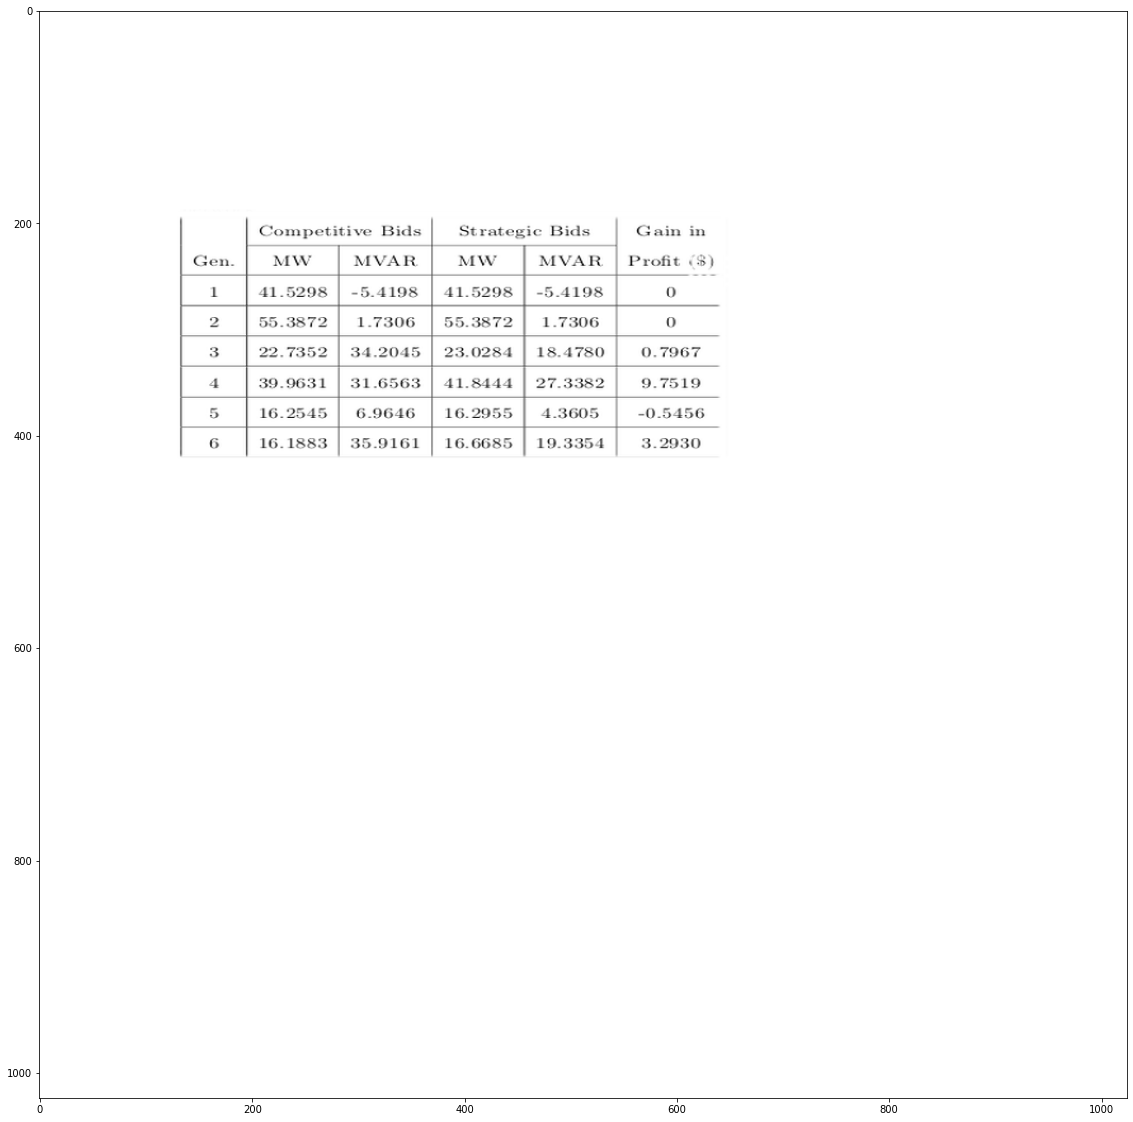

In [22]:
#showing cropped image with predicted mask
image = cv2.imread('output.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [23]:
#showing csv file
data

.1  .2  .3  .4  .5  .6       .7         .8       .9  .10      .11  \
0                                                                          
1                              Competi  tive Bids  Strate;       ic Bids   
2              1                   MW       MVAR       MW          MVAR   
3                                                                          
4                                                  55.3872                 
5                                        34.2045,  23.0284       18.4780   
6                                                                          
7                                                  16.2955                 
8                                         35.9161                          
9                                                                          
10                                                                         

         .12  
0             
1     Gain i  
2   Profit «  
3             
4             
5             
6             
7             
8             
9             
10

In [13]:
text('text.png')


       Competitive Bids Strategic Bids Gain in 
  Gen.  MW            MW           Profit $ 
f  1  asane  sos    farsa   sion    0 
   2  ow-are  ra   Pasanre 1200     0 
fa    e  rane asaoss fanoass incre  mor 
Fa    oains  aos    farses ara     0.70 
fe    frases fasoser sons  fioaase  a0 



# Conclusion:
1. i have train the TableNet model with 200 epochs which is very less compare to ask by the research paper . So accuracy is 
   compromising but still model is giving 95% f1 score for table mask and 86% f1 score for column mask.
   
2. Training model with marmot dataset which total file contained is 495 which excessively low when we are training deep learing 
   model. With limited GPU support , i am not able to run for more number of epoch which could have increase the f1 score ,    so the predicted table from the image is found to be little bit deflected from the actual table and in addition it has direct impact on converting table to csv file.
   
3. All the marmot file is found to be blurr, so the model was not able to predict the table apropriately which could be the reason for not predicting table properly. 

4. Tesseract OCR (pytesseract) work better for high resolution image as we have image with low resolution , therefore we could see for some table image , Tesseract OCR could not abe to convert image to text properly.

5. High resolution image with lots of data along with high GPU support could have improved the model performance immensely.

6. As i have train the model with marmot dataset , prediction is pretty much good marmot image compare to other image.

7. for some images , text conversion are also found to good but not for all, reason could be image quality, model prediction accuracy etc. 
    
